<a href="https://colab.research.google.com/github/Reevoc/MobileEsame/blob/master/Tumori_Benigni_Maligni_CNN_prova_finale1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Convolutional Neural Network

###Library




In [1]:
import numpy as np 
import os
import keras
import matplotlib.pyplot as plt
import tensorflow as tf

from google.colab.patches import cv2_imshow

from google.colab import drive
from tensorflow.python.client import device_lib
from PIL import Image
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
from keras import layers, models, Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ReduceLROnPlateau
from keras import backend
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix

####Usefull installation


#**Preparazione e download delle immagini**
Le immagini vengono scaricate da google drive, e convertite in array numpy.
Il dataset è composto da 4 cartelle già divise per tumori benigni e maligni per test e train.

In [2]:
!pip install pyyaml h5py

In [3]:
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [4]:
model_name = 'modello_con_77%' 
#os.mkdir(f'/content/drive/MyDrive/CNN_prove/{model_name}')
def save_model(model_name , model):
  model.save(f'/content/drive/MyDrive/CNN_prove/{model_name}')
  print("Saved model to google drive")

Prendo le folder che mi interesso e le carico definisco una lamba function per aprire le immagini in RGB

In [5]:
folder_benign_train = '/content/drive/MyDrive/Dati/train/benign'
folder_malignant_train = '/content/drive/MyDrive/Dati/train/malignant'

folder_benign_test = '/content/drive/MyDrive/Dati/test/benign'
folder_malignant_test = '/content/drive/MyDrive/Dati/test/malignant'

read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))

Le immagini vengono scaricate da google drive, e convertite in array numpy.
Il dataset è composto da 4 cartelle già divise per tumori benigni e maligni per test e train.

In [6]:
# Carico le immagini di train
ims_benign = [read(os.path.join(folder_benign_train, filename)) for filename in os.listdir(folder_benign_train)]
X_benign = np.array(ims_benign, dtype='uint8')
print("train beningi caricati")
ims_malignant = [read(os.path.join(folder_malignant_train, filename)) for filename in os.listdir(folder_malignant_train)]
X_malignant = np.array(ims_malignant, dtype='uint8')
print("train maligni caricati")

# Carico le immagini di test
ims_benign = [read(os.path.join(folder_benign_test, filename)) for filename in os.listdir(folder_benign_test)]
X_benign_test = np.array(ims_benign, dtype='uint8')
print("test beningi caricati")
ims_malignant = [read(os.path.join(folder_malignant_test, filename)) for filename in os.listdir(folder_malignant_test)]
X_malignant_test = np.array(ims_malignant, dtype='uint8')
print("test maligni caricati")

train beningi caricati
train maligni caricati
test beningi caricati
test maligni caricati


###Lables 
Aggiungo la lables a tutte le immagini 0 per un benigno e 1 per un maligno.

In [7]:
y_benign = np.zeros(X_benign.shape[0])
y_malignant = np.ones(X_malignant.shape[0])

y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])

print(y_benign.shape)
print(y_malignant.shape)

(1419,)
(1145,)


Concateno i set di train e di test e faccio uno shuffle delle dei tensori

In [8]:
X_train = np.concatenate((X_benign, X_malignant), axis = 0)
y_train = np.concatenate((y_benign, y_malignant), axis = 0)

X_test = np.concatenate((X_benign_test, X_malignant_test), axis = 0)
y_test = np.concatenate((y_benign_test, y_malignant_test), axis = 0)

s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
y_train = y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
y_test = y_test[s]

Una visualizzazione rapita compresa di lables delle immagni in una griglia 



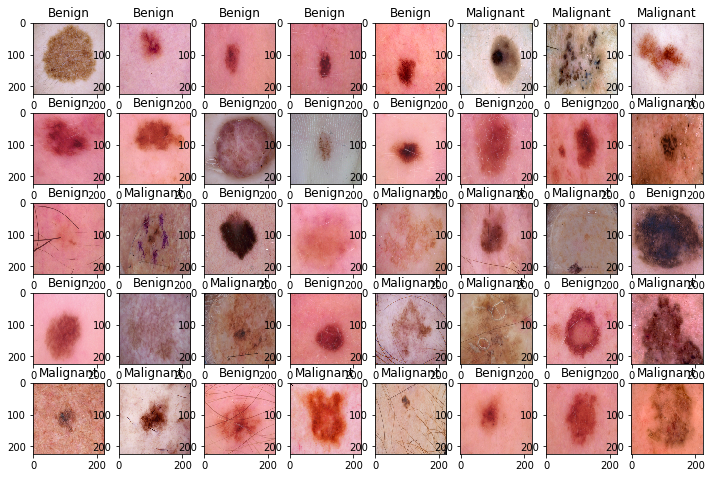

In [9]:
columns = 8
rows = 5
fig=plt.figure(figsize=(12, 8))

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation= 'nearest')
plt.show()

###Categorical Lables

In [10]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test =tf.keras.utils.to_categorical(y_test, num_classes=2)

###Normalizzo 
eseguo una normalizzazione delle immagini

In [11]:
X_train.astype('float32')
X_test.astype('float32')
X_train = (X_train - 127.5) / 127.5
X_test = (X_test - 127.5) /127.5
X_train.shape

(2564, 224, 224, 3)

#Build CNN model 
Il modello è basato su dei layer di Conv2D, e MaxPool2D.
Viene aggiunto anche un layer di dropout per evitare un overfitting della rete.
dopo varie prove ho optato per un'attivazione sigmoid e ottimizzatore rsmprop o softmax attivatore e adam ottimizzatore. Questi sembrano dare i risultati migliori.


In [12]:
#in optin da provare con rmsprop , adam e in activation_Dense con sigmoid , softmax
#aumento la complessità della rete e allungo le epoche 
def CNN_model(input_shape, lr, numclassi, optim, activ, init): 
    
    model = Sequential()

    model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',input_shape=input_shape,
                     activation= activ, kernel_initializer='glorot_uniform'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same', 
                     activation =activ, kernel_initializer = 'glorot_uniform'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same', 
                     activation =activ, kernel_initializer = 'glorot_uniform'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(512, activation='relu', kernel_initializer=init))
    model.add(Dense(numclassi, activation='sigmoid'))
    model.summary()

    if optim == 'rmsprop':
        optimizer = RMSprop(lr = lr)

    else:
        optimizer = Adam(lr=lr)

    model.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"])
    
    return model

###Learning rate reduction


In [13]:
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy', patience=5,  verbose=0, factor=0.5,  min_lr=1e-7)

###Plot
plot il modello in base ai valori di loss e accuracy ottenuti dal test train in fase di CNN_model

In [14]:
def plot(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']  
  val_loss = history.history['val_loss']
  epoches = range (1, len(acc)+1)

  plt.plot(epoches, acc, 'bo', label ='Traning accuracy')
  plt.plot(epoches, val_acc, 'b', label ='Validation accuracy')
  plt.title('Traning and Validation accuracy')
  plt.legend()
  plt.figure()

  plt.plot(epoches, loss, 'bo', label = 'Traning loss')
  plt.plot(epoches, val_loss, 'b', label ='Validation loss')
  plt.title('Traning and Validation loss')
  plt.legend()

  plt.show()
  
def plot_1(history):
  acc = history.history['accuracy']
  loss = history.history['loss']  
  epoches = range (1, len(acc)+1)

  plt.plot(epoches, acc, 'bo', label ='Traning accuracy')
  plt.title('Traning and Validation accuracy')
  plt.legend()
  plt.figure()

  plt.plot(epoches, loss, 'bo', label = 'Traning loss')
  plt.title('Traning and Validation loss')
  plt.legend()

  plt.show()

#Visualizzazione dei filtri


(1, 224, 224, 3)


<function matplotlib.pyplot.show>

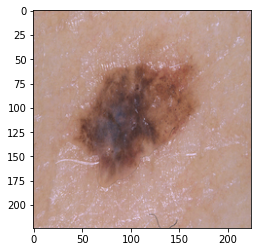

In [15]:
img_path = '/content/drive/MyDrive/Dati/train/benign/photo10.jpg'
img = image.load_img(img_path, target_size = (224, 224))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis = 0)
img_tensor /= 255.
print(img_tensor.shape)
plt.imshow(img_tensor[0])
plt.show

In [16]:
layers_outputs = [layer.output 
                 for layer in model.layers[:8]]
activation_model = models.Model(inputs = model.input, outputs = layers_outputs)
activation = activation_model.predict(img_tensor)
first_layer_activation = activation[0]
print(first_layer_activation.shape)

NameError: ignored

In [ ]:
plt.imshow(first_layer_activation[0,:,:,2], cmap = 'gray')

In [ ]:
plt.imshow(first_layer_activation[0,:,:,9], cmap = 'gray')

In [ ]:
plt.imshow(first_layer_activation[0,:,:,13], cmap = 'gray')

In [ ]:
"""layers_names = []

for layer in model.layers[:8]: #quanti layer ho ??
  layers_names.append(layer.name)

images_per_row = 16
for layer_name, layer_activation in zip(layers_names, activation):
  n_features = layer_activation.shape[-1]
  size = layer_activation.shape[1]
  n_cols = n_features // images_per_row
  display_grid = np.zeros((size * n_cols, images_per_row * size))
  for col in range(n_cols):
    for row in range(images_per_row):
      channel_image = layer_activation[0,:,:,col *images_per_row + row]
      channel_image -= channel_image.mean()
      channel_image /= channel_image.std()
      channel_image *= 64
      channel_image +=128
      channel_image = np.clip(channel_image, 0 , 255).astype('uint8')
      display_grid[col * size : (col +1) * size, row * size : (row +1)* size ] = channel_image
  scale = 1./ size
  plt.figure(figsize = (scale * display_grid.shape[1], scale * display_grid.shape[0]))
  plt.title(layer_name)
  plt.grid(False)
  plt.imshow(display_grid, aspect = 'auto', cmap = 'gray')"""

#Train the Model


In [17]:
model = CNN_model(lr=1e-5,
                  numclassi = 2,
                  activ= 'relu',
                  optim='adam',
                  input_shape= (224,224,3),
                  init = 'normal')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        3

Epoch 1/50
17/17 [==============================] - 10s 185ms/step - loss: 0.8974 - accuracy: 0.5210 - val_loss: 0.7023 - val_accuracy: 0.4756
Epoch 2/50
17/17 [==============================] - 3s 164ms/step - loss: 0.7983 - accuracy: 0.5411 - val_loss: 0.6527 - val_accuracy: 0.6082
Epoch 3/50
17/17 [==============================] - 3s 160ms/step - loss: 0.7601 - accuracy: 0.5861 - val_loss: 0.6401 - val_accuracy: 0.6355
Epoch 4/50
17/17 [==============================] - 3s 160ms/step - loss: 0.6970 - accuracy: 0.6324 - val_loss: 0.6216 - val_accuracy: 0.6452
Epoch 5/50
17/17 [==============================] - 3s 162ms/step - loss: 0.7064 - accuracy: 0.6210 - val_loss: 0.6073 - val_accuracy: 0.6413
Epoch 6/50
17/17 [==============================] - 3s 160ms/step - loss: 0.6840 - accuracy: 0.6318 - val_loss: 0.5966 - val_accuracy: 0.6628
Epoch 7/50
17/17 [==============================] - 3s 160ms/step - loss: 0.6427 - accuracy: 0.6576 - val_loss: 0.5859 - val_accuracy: 0.6784
Epoch

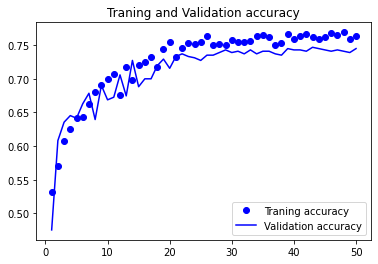

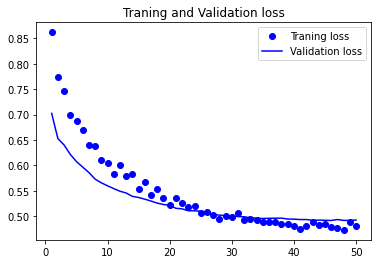

In [18]:
history = model.fit(X_train,
                    y_train,
                    validation_split=0.2,
                    epochs= 50,
                    batch_size= 128,
                    verbose=1, 
                    callbacks=[learning_rate_reduction])
plot(history)
del history

##Cross Validation

In [19]:
def cross_validation(model, input_shape, lr, activ, optim, epochs):
  inputs = np.concatenate((X_train, X_test), axis = 0)
  targets = np.concatenate((y_train, y_test), axis = 0)

  #3 k fold
  kfold = KFold(n_splits=3, shuffle=True)
  print(f'values kfold = {kfold}')

  #dove metto gli score
  acc_per_fold = []
  loss_per_fold = []
  fold_no = 1

  for train, test in kfold.split(inputs, targets):
    
      #Addestro il modello su una parte dei dati di train
      model.fit(inputs[train], targets[train], epochs=epochs, batch_size= 128, verbose=0)
    
      #score del modello in percentuale
      scores = model.evaluate(inputs[test], targets[test], verbose=0)
      acc_per_fold.append(scores[1] * 100)
      loss_per_fold.append(scores[0])

      # Increase fold number
      fold_no = fold_no + 1

  for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
  print('------------------------------------------------------------------------')
  print('Media degli scores per tutte le folds:')
  print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
  print(f'> Loss: {np.mean(loss_per_fold)}')
  print('------------------------------------------------------------------------')

In [20]:
cross_validation(model = model,
                 input_shape= (224,224,3),
                 lr=1e-5,
                 activ= 'relu',
                 optim='adam',
                 epochs = 40)

values kfold = KFold(n_splits=3, random_state=None, shuffle=True)
------------------------------------------------------------------------
> Fold 1 - Loss: 0.4983544945716858 - Accuracy: 74.88328814506531%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.47862064838409424 - Accuracy: 77.49766707420349%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.46974706649780273 - Accuracy: 78.50467562675476%
------------------------------------------------------------------------
Media degli scores per tutte le folds:
> Accuracy: 76.96187694867452 (+- 1.5261968237190189)
> Loss: 0.4822407364845276
------------------------------------------------------------------------


In [21]:
save_model(model = model, model_name = 'modello_con_75%')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/CNN_prove/modello_con_77%/assets
Saved model to google drive


##Data Agumentation

In [22]:
def manually_data_agumetation(batches, model, epochs, X_train, y_train):
  
  #funzione di data agumentation 
  datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2)
  
  datagen.fit(X_train)
  print(X_train.shape)
  learning_rate_reduction = ReduceLROnPlateau(monitor = 'accuracy', patience=10,  verbose=0, factor=0.5,  min_lr=1e-7)

  history = model.fit(datagen.flow(X_train, y_train, batch_size= 256),
           steps_per_epoch = len(X_train) / 32,
           epochs = epochs,
           batch_size = batches,
           validation_steps = 0.2,
           verbose = 1,
           callbacks = learning_rate_reduction)
  
  plot_1(history)
  del history
  return model

#Generated image DCGAN 

###salva immagini

In [37]:
def save_images(directory, generator, val):
  #devo mettere il numero di sample che voglio generare 
    for k in range(val):
        #devo mettere il mio generatore
        generated_image = generator(tf.random.normal([1, 100]), training=False)
        f = str(k) + '.png'
        f = os.path.join(directory, f)
        img = np.array(generated_image)
        img = (img[0, :, :, :] + 1.) / 2.
        #devo fare il reshape con i valori dell'immagine che ho 
        image_height = 224  
        image_width = 224 
        image_channels = 3
        img = Image.fromarray((255*img).astype('uint8').reshape((image_height, image_width, image_channels)))
        img.save(f,'PNG')
        #if k % 1000==0: print(k)
    print('Saved temporary images for evaluation.')

##Genera immagini

In [39]:
model_name_folder = 'modello_n_11'
model_name_b = 'modello_benigni'
val_1 = int(1419 / 4)
val_2 = int( 1145 / 4)
os.mkdir(f'/content/drive/MyDrive/CNN_prove/{model_name}/images_final_b3')
reconstructed_model_benign = keras.models.load_model(f'/content/drive/MyDrive/DCGAN/{model_name_folder}/{model_name_b}')
save_images(f'/content/drive/MyDrive/CNN_prove/{model_name}/images_final_b3',
          reconstructed_model_benign, val_1)
folder_benign_train = f'/content/drive/MyDrive/CNN_prove/{model_name}/images_final_b3'
model_name_m = 'modello_maligni'
os.mkdir(f'/content/drive/MyDrive/CNN_prove/{model_name}/images_final_m')
reconstructed_model_malignant = keras.models.load_model(f'/content/drive/MyDrive/DCGAN/{model_name_folder}/{model_name_m}')
save_images(f'/content/drive/MyDrive/CNN_prove/{model_name}/images_final_m',
            reconstructed_model_malignant, val_2)
folder_malignant_test = f'/content/drive/MyDrive/CNN_prove/{model_name}/images_final_m'

Saved temporary images for evaluation.
Saved temporary images for evaluation.


In [41]:
ims_benign_g = [read(os.path.join(folder_benign_train, filename)) for filename in os.listdir(folder_benign_train)]
X_benign_generated = np.array(ims_benign_g, dtype='uint8')
print("generated beningi caricati")
print(X_benign_generated.shape)

generated beningi caricati


In [42]:
ims_malignant_g = [read(os.path.join(folder_malignant_test, filename)) for filename in os.listdir(folder_malignant_test)]
X_malignant_genereted = np.array(ims_malignant_g, dtype='uint8')
print("generated maligni caricati")
print(X_malignant_genereted.shape)

generated maligni caricati


Lables 1 per maligni 0 per benigni

In [44]:
y_benign_generated = np.zeros(X_benign_generated.shape[0])
print(y_benign_generated.shape)
y_malignant_generated = np.ones(X_malignant_genereted.shape[0])
print(y_malignant_generated.shape)

(354,)
(286,)


Concateno gli array numpy con le lables create in precedenza

In [50]:
#Conateno le false
X_generated = np.concatenate((X_benign_generated, X_malignant_genereted), axis = 0)
y_generated = np.concatenate((y_benign_generated, y_malignant_generated), axis = 0)
X_generated.astype('float32')
X_generated= (X_generated - 127.5) /127.5
print(X_generated.shape)
print(y_generated.shape)

(640, 224, 224, 3)
(640,)


In [51]:
Full_train_X = np.concatenate((X_generated, X_train), axis = 0)
print(Full_train_X.shape)
y_generated = tf.keras.utils.to_categorical(y_generated, num_classes=2)
Full_train_y = np.concatenate((y_generated, y_train), axis = 0)
print(Full_train_y.shape)

(3204, 224, 224, 3)
(3204, 2)


###Generate + Normali + dataagumentation

(3204, 224, 224, 3)
Epoch 1/50
12/12 [==============================] - 28s 2s/step - loss: 0.7019 - accuracy: 0.7937
Epoch 2/50
12/12 [==============================] - 28s 2s/step - loss: 0.6774 - accuracy: 0.8009
Epoch 3/50
12/12 [==============================] - 28s 2s/step - loss: 0.6635 - accuracy: 0.7971
Epoch 4/50
12/12 [==============================] - 28s 2s/step - loss: 0.6438 - accuracy: 0.7937
Epoch 5/50
12/12 [==============================] - 28s 2s/step - loss: 0.6265 - accuracy: 0.7962
Epoch 6/50
12/12 [==============================] - 28s 2s/step - loss: 0.6468 - accuracy: 0.7903
Epoch 7/50
12/12 [==============================] - 28s 2s/step - loss: 0.6337 - accuracy: 0.7956
Epoch 8/50
12/12 [==============================] - 28s 2s/step - loss: 0.6111 - accuracy: 0.7943
Epoch 9/50
12/12 [==============================] - 28s 2s/step - loss: 0.6019 - accuracy: 0.7959
Epoch 10/50
12/12 [==============================] - 28s 2s/step - loss: 0.5988 - accuracy: 0.7959

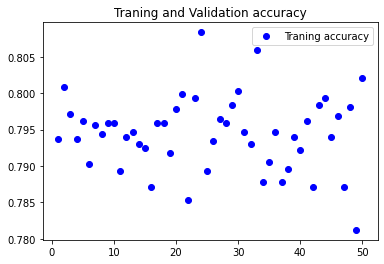

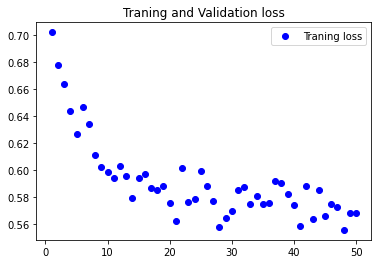

In [53]:
model_with_generated = manually_data_agumetation(256, model, 30, Full_train_X, Full_train_y)

In [54]:
scores = model_with_generated.evaluate(X_test, y_test, verbose=0)
acc_per_fold = (scores[1] * 100)
loss_per_fold = (scores[0])
print(f'> Loss: {loss_per_fold} - Accuracy: {acc_per_fold}%')

> Loss: 0.5248224139213562 - Accuracy: 77.77777910232544%


###Generate + Normali + senza data agu

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 56, 56, 64)       

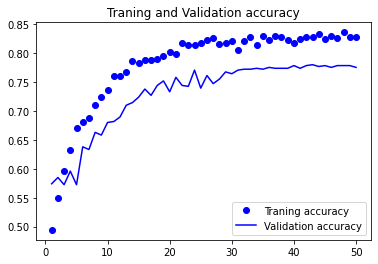

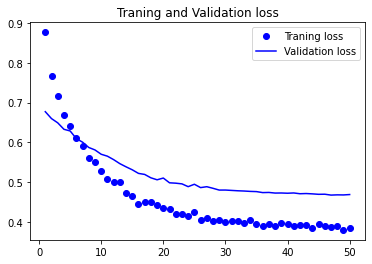

In [55]:
model1 = CNN_model(lr=1e-5,
                  numclassi = 2,
                  activ= 'relu',
                  optim='adam',
                  input_shape= (224,224,3),
                  init = 'normal')

history = model1.fit(Full_train_X,
                     Full_train_y,
                      validation_split=0.2,
                      epochs= 50,
                      batch_size= 128,
                      verbose=1, 
                      callbacks=[learning_rate_reduction])
plot(history)
del history

In [56]:
scores = model1.evaluate(X_test, y_test, verbose=0)
acc_per_fold = (scores[1] * 100)
loss_per_fold = (scores[0])
print(f'> Loss: {loss_per_fold} - Accuracy: {acc_per_fold}%')

> Loss: 0.4766403138637543 - Accuracy: 76.54321193695068%


###Normali + dataagument

(2564, 224, 224, 3)
Epoch 1/50
10/10 [==============================] - 23s 2s/step - loss: 0.6500 - accuracy: 0.7679
Epoch 2/50
10/10 [==============================] - 23s 3s/step - loss: 0.6282 - accuracy: 0.7738
Epoch 3/50
10/10 [==============================] - 23s 2s/step - loss: 0.6064 - accuracy: 0.7800
Epoch 4/50
10/10 [==============================] - 22s 2s/step - loss: 0.6306 - accuracy: 0.7715
Epoch 5/50
10/10 [==============================] - 23s 2s/step - loss: 0.6438 - accuracy: 0.7730
Epoch 6/50
10/10 [==============================] - 23s 2s/step - loss: 0.6482 - accuracy: 0.7742
Epoch 7/50
10/10 [==============================] - 23s 2s/step - loss: 0.6423 - accuracy: 0.7789
Epoch 8/50
10/10 [==============================] - 22s 2s/step - loss: 0.6609 - accuracy: 0.7722
Epoch 9/50
10/10 [==============================] - 22s 2s/step - loss: 0.6090 - accuracy: 0.7843
Epoch 10/50
10/10 [==============================] - 23s 2s/step - loss: 0.6056 - accuracy: 0.7828

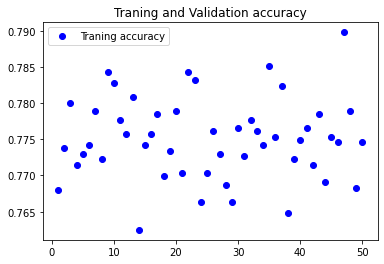

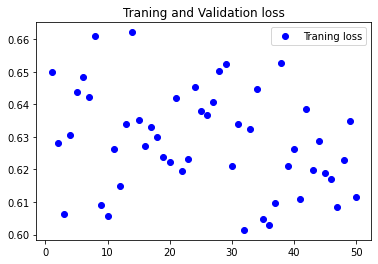

In [57]:
model_with_generated1 = manually_data_agumetation(256, model, 30, X_train, y_train)

In [58]:
scores = model_with_generated1.evaluate(X_test, y_test, verbose=0)
acc_per_fold = (scores[1] * 100)
loss_per_fold = (scores[0])
print(f'> Loss: {loss_per_fold} - Accuracy: {acc_per_fold}%')

> Loss: 0.5345522165298462 - Accuracy: 77.16049551963806%
